In [184]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os
import datetime as dt
from datetime import datetime,timedelta
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 24
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 17
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
RESULTS_DIR_F = os.path.join(ROOT_DIR, "results_filtered")


In [185]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

   
def prepare_topics(dfa,lag,threshold):
    df=dfa.copy()

    # padding empty columns, sorting columns
    for i in range(0,100):
        if f"Topic_{i}" not in df.columns:
            df[f"Topic_{i}"] = 0
    df = df[df.columns[df.columns.str[6:].astype(float).argsort()]]

    dataframe=df

    for i in range(0,100):
        arr = df.to_numpy()
        y = arr[:,i]

        result = thresholding_algo(y, lag, threshold, influence=0)
        avg_filter = result["avgFilter"]
        threshold_filter = result["avgFilter"] + threshold * result["stdFilter"]
        signals = result["signals"]
        
        for j in range(0,len(signals)):
            if signals[j] < 1:
                signals[j] = -5
            else:
                signals[j] = y[j]

        dataframe[f"avg_filter_topic_{i}"] = avg_filter
        dataframe[f"threshold_filter_topic_{i}"] = threshold_filter
        dataframe[f"signals_topic_{i}"] = signals
        dataframe[f"y_{i}"] = y

    return dataframe
    

In [186]:
def multi_line_peaks_plot(df, title, threshold):

    topics = [f"Topic_{i}" for i in range(0,100)]
    topics = [i for i in topics if i in df.columns]
    series = [df[topic] for topic in topics]

    cm = plt.get_cmap('nipy_spectral')
    topic_count = len(series)
    cNorm  = colors.Normalize(vmin=0, vmax=topic_count-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_list = [scalarMap.to_rgba(i) for i in range(0,topic_count)]
    
    fig, ax = plt.subplots(figsize=(25, 7))

    ax.locator_params(axis="x", nbins=12)
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)

    for data, color, topic in zip(series, color_list, topics):
        maxim = data.nlargest(2)
        if max(data) >= threshold:
            ax.plot(data.index.values, data, color=color, lw=0.8, alpha=0.7, label=topic)
            # for item in maxim:
            #     ax.vlines(x=[df.index[df[topic] == item]], ymin=0, ymax=250, color=color, lw=1, alpha=1)

    ax.set(title=title, xbound=(beginning, end),ylim=(0))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    #ax.yaxis.set_ticks([-1,0,1])
    # fig.legend(loc='center left', bbox_to_anchor=(1, 0))
    
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")

    return fig

In [187]:
# 1. BATTLES, ATTACKS AND CONSEQUENCES - 17 22 33 55 60 72 96 99
# 2. POLITICS - 2 4 7 10 11 14 21 30 34 39 56 57 58 65 70 73 75 80 98
# 3. PRICES/SUPPLY CHAIN/SANCTIONS - 24 29 44 47 52 54 82 84 95
# 4. REFUGEES - 19 38 97 
# 5. ARTILLERY AND TROOPS - 20 35 43 46 51 63 79 81 86 
# 6. MISC - 3 6 9 25 50 59 66 

def filtered_multi_lines_peaks_plot(df, kwargs,limit):
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"

    uniques = []
    for i in kwargs["All"]:
        topic = i["topic"]
        lag = i["lag"]
        threshold = i["threshold"]
        topic_data = prepare_topics(df,lag,threshold)
        signals = topic_data[f"signals_topic_{topic}"]
        y = topic_data[f"y_{topic}"]
        colors = {
            "red":[17, 22, 33, 55, 60, 72, 96, 99],
            "blue":[2, 4, 7, 10, 11, 14, 21, 30, 34, 39, 56, 57, 58, 65, 70, 73, 75, 80, 98],
            "magenta":[24, 29, 44, 47, 52, 54, 82, 84, 95,],
            "cyan":[19, 38, 97],
            "green":[20, 35, 43, 46, 51, 63, 79, 81, 86],
            "grey":[3, 6, 9, 25, 50, 59, 66],
        }
        color="green"
        for i in colors.items():
            if topic in i[1]:
                color = i[0]
        labels = {
            "red":"Battles, Attacks and Effects of War",
            "blue":"Politics",
            "magenta":"Prices, Supply Chain and Sanctions",
            "cyan":"Refugees and Victims",
            "green":"Artillery and Troops",
            "grey":"Other",
        }
        if color not in uniques:
            label = labels[color]
            uniques.append(color)
        else:
            label = None

        if max(signals) >= limit:
            ax.step(topic_data.index.values, signals,c=color, lw=0.8, alpha=1, label = label)

        # for i in range(len(signals)):
        #     if signals[i] in sorted(signals, reverse=True)[:2]:
        #         ax.text(topic_data.index.values[i], signals[i], str(signals[i]), ha='center', va='bottom', fontsize=8)

    ax.set(title=title, xbound=(beginning, end), ylim=(0))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    #ax.yaxis.set_ticks([-1,0,1])]]
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    L = ax.legend()
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    
    plt.show()
    return fig

In [188]:
kwargs = {
    "All":[
    {"topic":2,"lag":240,"threshold":5},
    {"topic":3,"lag":300,"threshold":5},
    {"topic":4,"lag":235,"threshold":5},
    {"topic":6,"lag":240,"threshold":5},
    {"topic":7,"lag":300,"threshold":5},
    {"topic":9,"lag":190,"threshold":5},
    {"topic":10,"lag":300,"threshold":5},
    {"topic":11,"lag":235,"threshold":5},
    {"topic":14,"lag":240,"threshold":5},
    {"topic":17,"lag":240,"threshold":6},
    {"topic":19,"lag":243,"threshold":5},
    {"topic":20,"lag":290,"threshold":5},
    {"topic":21,"lag":235,"threshold":5},
    {"topic":22,"lag":240,"threshold":7},
    {"topic":24,"lag":230,"threshold":6},
    {"topic":25,"lag":240,"threshold":9},
    {"topic":29,"lag":235,"threshold":9},
    {"topic":30,"lag":340,"threshold":7},
    {"topic":33,"lag":240,"threshold":7},
    {"topic":34,"lag":250,"threshold":5},
    {"topic":35,"lag":195,"threshold":2},
    {"topic":38,"lag":239,"threshold":5},
    {"topic":39,"lag":250,"threshold":8},
    {"topic":43,"lag":241,"threshold":4},
    {"topic":44,"lag":235,"threshold":5},
    {"topic":46,"lag":250,"threshold":5},
    {"topic":47,"lag":240,"threshold":5},
    {"topic":50,"lag":235,"threshold":6},
    {"topic":51,"lag":258,"threshold":5},
    {"topic":52,"lag":243,"threshold":5},
    {"topic":54,"lag":240,"threshold":6},
    {"topic":55,"lag":270,"threshold":10},
    {"topic":56,"lag":440,"threshold":5},
    {"topic":57,"lag":238,"threshold":6},
    {"topic":58,"lag":239,"threshold":4},
    {"topic":59,"lag":238,"threshold":5},
    {"topic":60,"lag":470,"threshold":5},
    {"topic":61,"lag":240,"threshold":5},
    {"topic":63,"lag":445,"threshold":8},
    {"topic":65,"lag":230,"threshold":6},
    {"topic":66,"lag":240,"threshold":5},
    {"topic":70,"lag":280,"threshold":9},
    {"topic":72,"lag":290,"threshold":5},
    {"topic":73,"lag":240,"threshold":6},
    {"topic":75,"lag":190,"threshold":6},
    {"topic":79,"lag":240,"threshold":6},
    {"topic":80,"lag":210,"threshold":5},
    {"topic":81,"lag":238,"threshold":14},
    {"topic":82,"lag":240,"threshold":5},
    {"topic":84,"lag":330,"threshold":5},
    {"topic":86,"lag":270,"threshold":6},
    {"topic":95,"lag":240,"threshold":5},
    {"topic":96,"lag":247,"threshold":5},
    {"topic":97,"lag":240,"threshold":3},
    {"topic":98,"lag":218,"threshold":6},
    {"topic":99,"lag":240,"threshold":5},
    ]
}

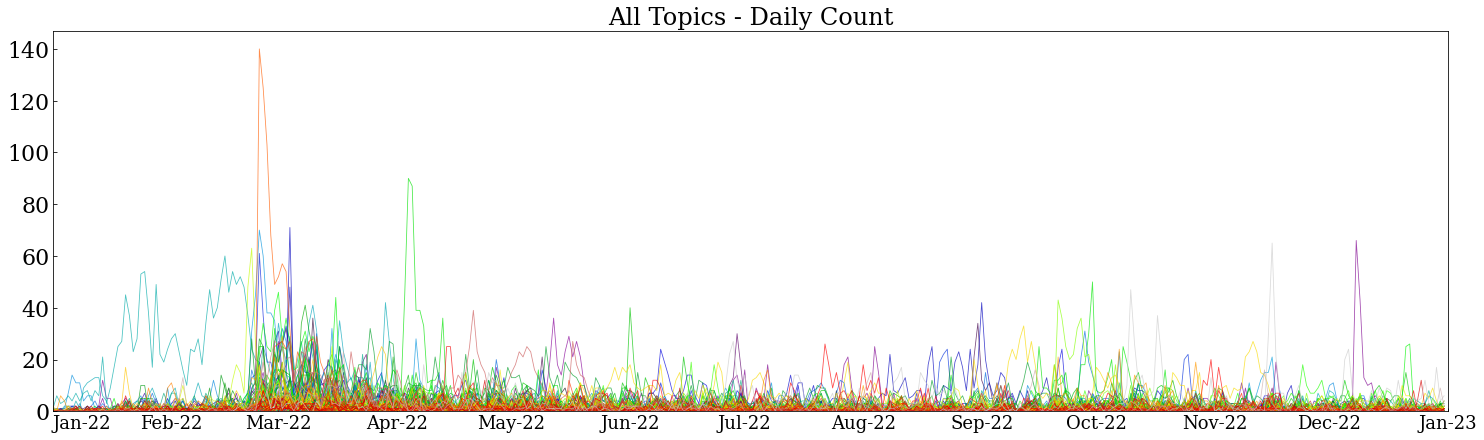

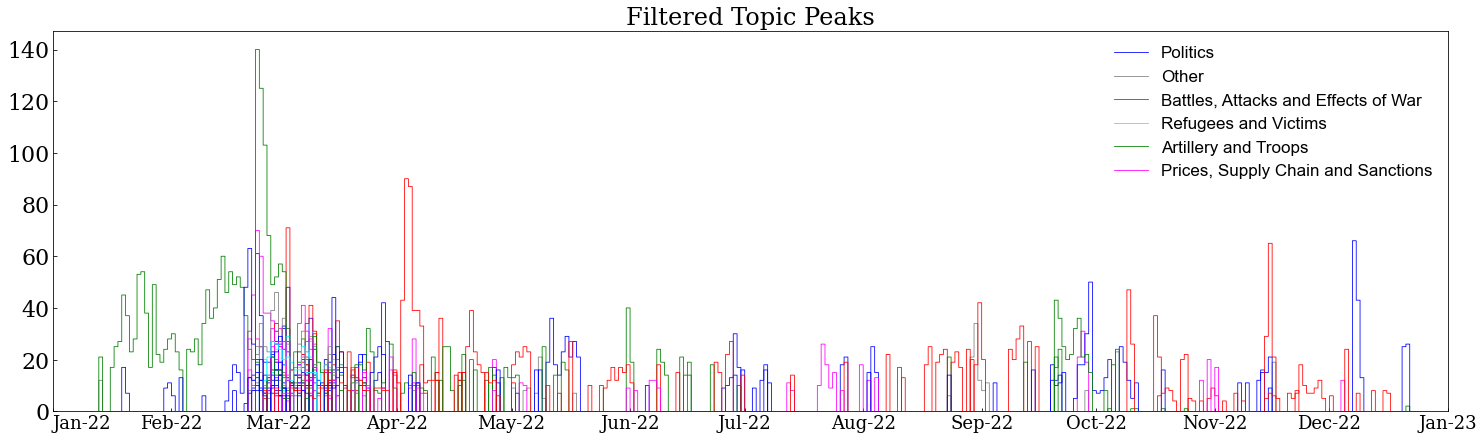

In [189]:
data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_1", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
data_df = data_df.drop(columns=["Title", "Text", "URL","Novelty","Resonance","Transience"])
data_df = pd.get_dummies(data_df, columns=['Topic'])
data_df = data_df.resample("D").sum()
#data_df = data_df.drop(columns=['Topic_0', 'Topic_1', 'Topic_5', 'Topic_8', 'Topic_11', 'Topic_12', 'Topic_13', 'Topic_15', 'Topic_16', 'Topic_18', 'Topic_23', 'Topic_26', 'Topic_27', 'Topic_28', 'Topic_31', 'Topic_32', 'Topic_36', 'Topic_40', 'Topic_41', 'Topic_42', 'Topic_45', 'Topic_48', 'Topic_49', 'Topic_53', 'Topic_62', 'Topic_64', 'Topic_67', 'Topic_68', 'Topic_69', 'Topic_71', 'Topic_74', 'Topic_76', 'Topic_77', 'Topic_78', 'Topic_83', 'Topic_85', 'Topic_87', 'Topic_88', 'Topic_89', 'Topic_90', 'Topic_91', 'Topic_92', 'Topic_93', 'Topic_94'])
fig = multi_line_peaks_plot(data_df, f"All Topics - Daily Count", threshold=0)
fig.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Full_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")

fig2 = filtered_multi_lines_peaks_plot(data_df,kwargs,0)
fig2.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Filtered_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")

In [200]:
# 1. BATTLES, ATTACKS AND CONSEQUENCES - 17 22 33 55 60 72 96 99
# 2. POLITICS - 2 4 7 10 11 14 21 30 34 39 56 57 58 65 70 73 75 80 98
# 3. PRICES/SUPPLY CHAIN/SANCTIONS - 24 29 44 47 52 54 82 84 95
# 4. REFUGEES - 19 38 97 
# 5. ARTILLERY AND TROOPS - 20 35 43 46 51 63 79 81 86 
# 6. MISC - 3 6 9 25 50 59 66 

def filtered_multi_lines_peaks_plot(df, kwargs,limit,chosen_cat,lim):
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"

    uniques = []
    for i in kwargs["All"]:
        topic = i["topic"]
        lag = i["lag"]
        threshold = i["threshold"]
        topic_data = prepare_topics(df,lag,threshold)
        signals = topic_data[f"signals_topic_{topic}"]
        y = topic_data[f"y_{topic}"]

        cats = {
            "bat":[17, 22, 33, 55, 60, 72, 96, 99],
            "pol":[4, 7, 10, 14, 21, 30, 34, 39, 56, 57, 58, 65, 70, 73, 75, 80, 98],
            "pri":[2, 24, 29, 44, 47, 52, 54, 82, 84, 95,],
            "ref":[19, 38, 97],
            "art":[20, 35, 43, 46, 51, 63, 79, 81, 86],
            "oth":[3, 6, 9, 25, 50, 59, 66],
        }
        titles = {
            "bat":"Battles, Attacks and Effects of War",
            "pol":"Politics",
            "pri":"Prices, Supply Chain and Sanctions",
            "ref":"Refugees and Victims",
            "art":"Artillery and Troops",
            "oth":"Other",
        }

        cat=""
        for i in cats.items():
            if topic in i[1]:
                cat = i[0]
        
        if max(signals) >= limit and cat == chosen_cat:
            ax.step(topic_data.index.values, signals, lw=1, alpha=1,label=topic)

        for i in range(len(signals)):
            if signals[i] >= lim and cat == chosen_cat:
                ax.text(topic_data.index.values[i], signals[i], str(int(signals[i])), ha='center', va='bottom', fontsize=9)

    ax.set(title=f"{titles[chosen_cat]} - Peaks", xbound=(beginning, end), ylim=(0))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    L = ax.legend()
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    
    plt.show()
    return fig

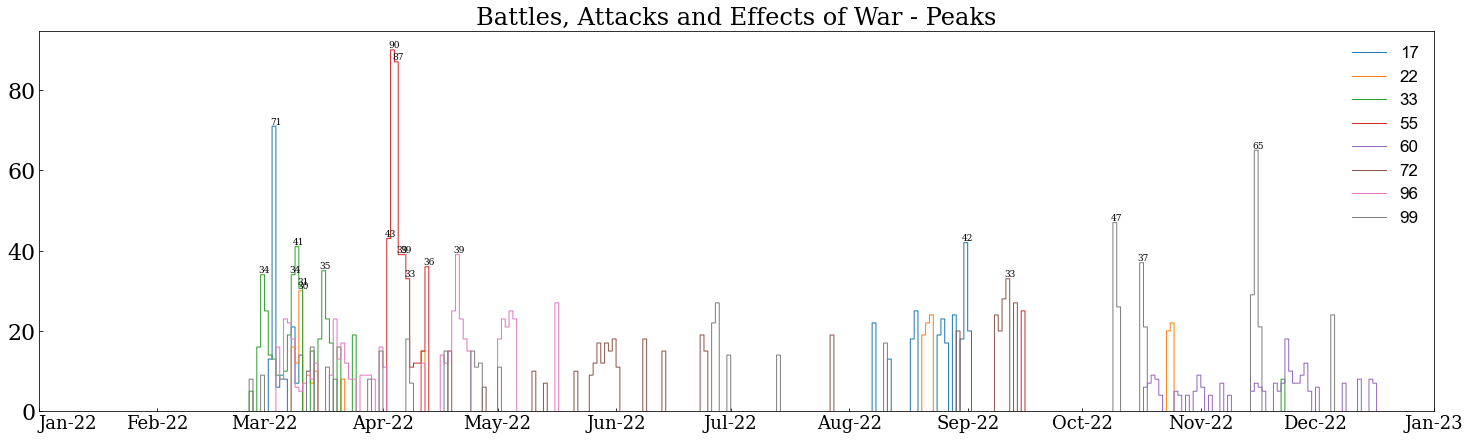

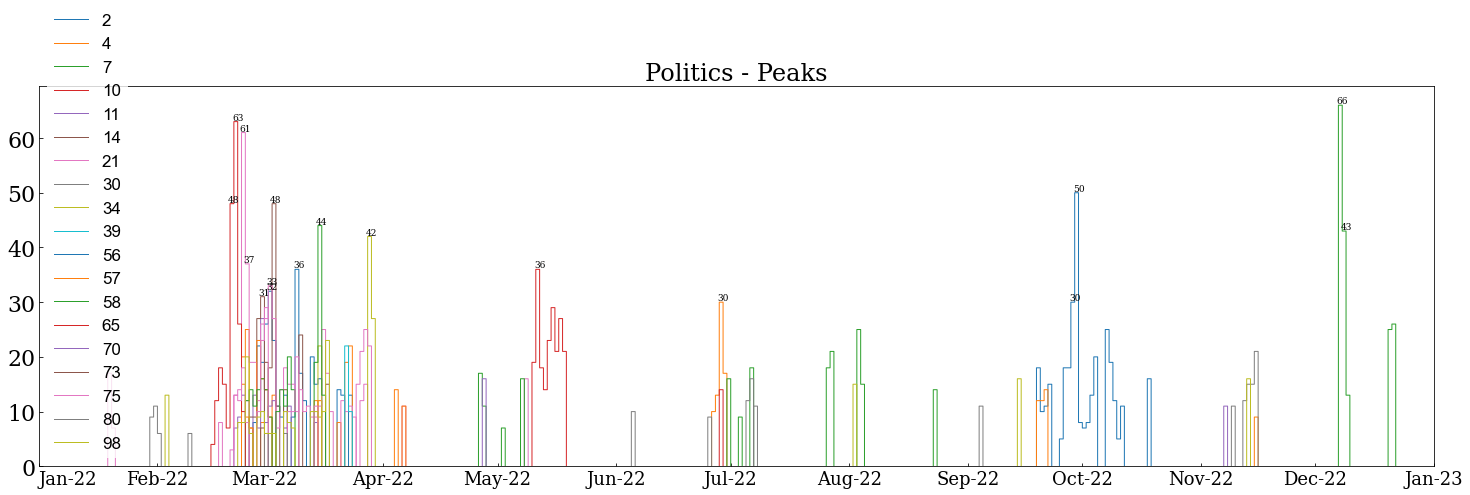

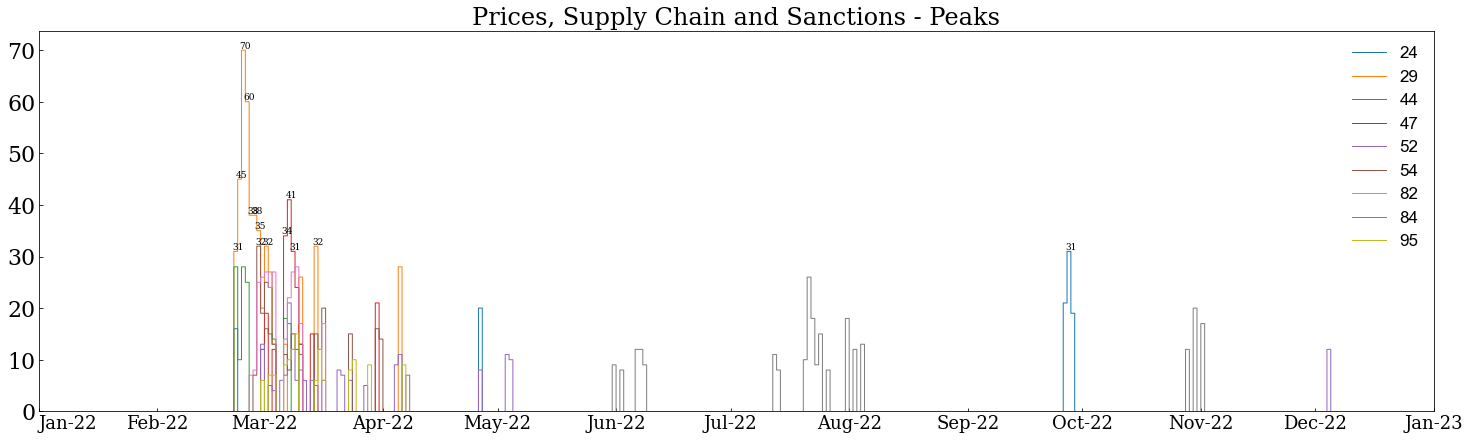

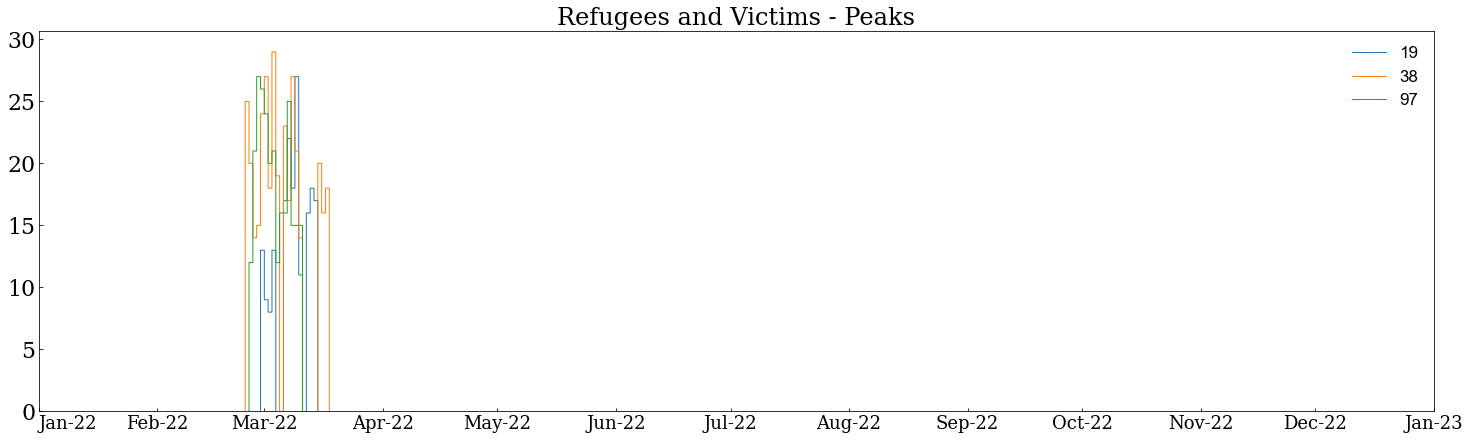

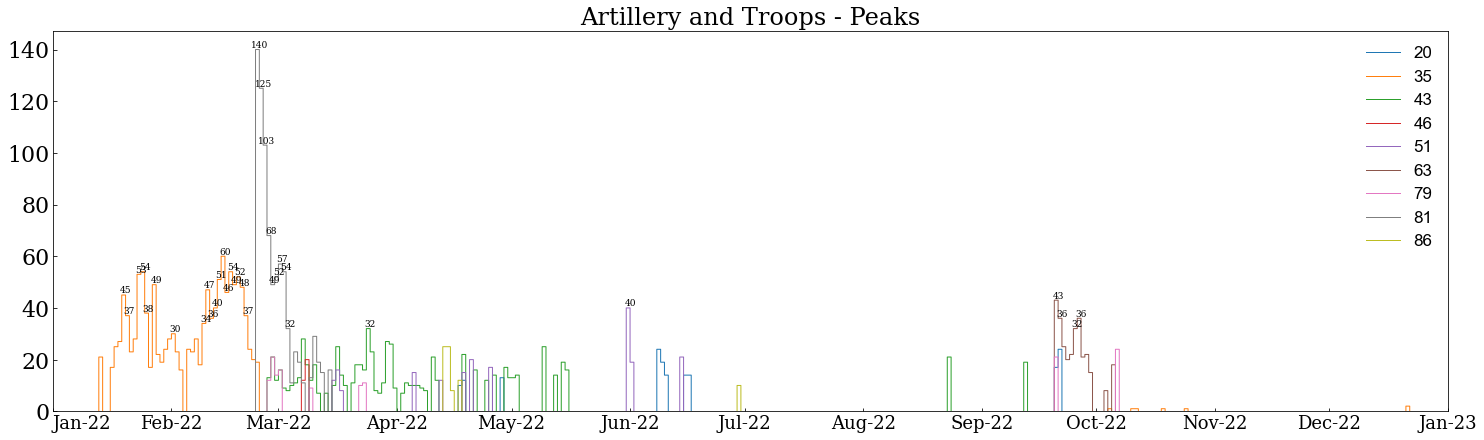

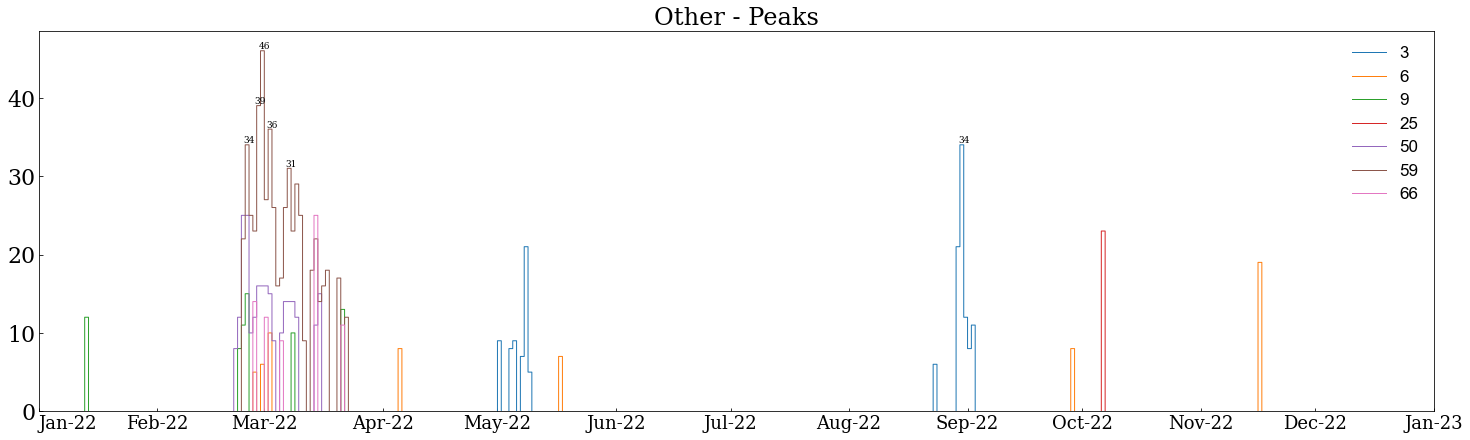

In [201]:
for f in ['bat','pol','pri','ref','art','oth']:
    fig3 = filtered_multi_lines_peaks_plot(data_df,kwargs,0,f,lim=30)
# fig2.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Filtered_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")